In [3]:
# example from https://github.com/pytorch/examples/blob/master/vae/main.py
# commented and type annotated by Charl Botha <cpbotha@vxlabs.com>

import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

In [4]:
# Plot the data

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1].item()))

In [5]:
# changed configuration to this instead of argparse for easier interaction

CUDA = False
SEED = 1
BATCH_SIZE = 128
LOG_INTERVAL = 10
EPOCHS = 25

In [6]:

# DataLoader instances will load tensors directly into GPU memory
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

In [7]:
# connections through the autoencoder bottleneck
# in the pytorch VAE example, this is 20

ZDIMS = 20

In [8]:
# Create and print the training dataset

train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transforms.ToTensor())
print("Print the training dataset:\n ", train_dataset)


# Create and print the validating dataset

validation_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())
print("Print the validating dataset:\n ", validation_dataset)

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
Print the validating dataset:
  Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test


In [9]:
train_dataset[59999][1]

8

AttributeError: 'int' object has no attribute 'item'

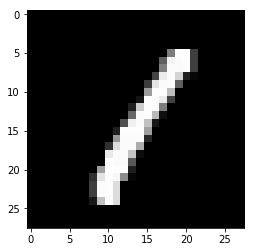

In [10]:
# Plot the image

print("The image: ", show_data(train_dataset[3]))

print(train_dataset[0][0].shape)

In [11]:
# shuffle data at every epoch
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

# Same for test data
test_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [12]:
torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

In [13]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # ENCODER
        # 28 x 28 pixels = 784 input pixels, 400 outputs
        self.fc1 = nn.Linear(784, 400)
        # rectified linear unit layer from 400 to 400
        # max(0, x)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, ZDIMS)  # mu layer
        self.fc22 = nn.Linear(400, ZDIMS)  # logvariance layer
        # this last layer bottlenecks through ZDIMS connections

        # DECODER
        # from bottleneck to hidden 400
        self.fc3 = nn.Linear(ZDIMS, 400)
        # from hidden 400 to 784 outputs
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x: Variable) -> (Variable, Variable):
        """Input vector x -> fully connected 1 -> ReLU -> (fully connected
        21, fully connected 22)

        Parameters
        ----------
        x : [128, 784] matrix; 128 digits of 28x28 pixels each

        Returns
        -------

        (mu, logvar) : ZDIMS mean units one for each latent dimension, ZDIMS
            variance units one for each latent dimension

        """

        # h1 is [128, 400]
        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        """THE REPARAMETERIZATION IDEA:

        For each training sample (we get 128 batched at a time)

        - take the current learned mu, stddev for each of the ZDIMS
          dimensions and draw a random sample from that distribution
        - the whole network is trained so that these randomly drawn
          samples decode to output that looks like the input
        - which will mean that the std, mu will be learned
          *distributions* that correctly encode the inputs
        - due to the additional KLD term (see loss_function() below)
          the distribution will tend to unit Gaussians

        Parameters
        ----------
        mu : [128, ZDIMS] mean matrix
        logvar : [128, ZDIMS] variance matrix

        Returns
        -------

        During training random sample from the learned ZDIMS-dimensional
        normal distribution; during inference its mean.

        """

        if self.training:
            # multiply log variance with 0.5, then in-place exponent
            # yielding the standard deviation
            std = logvar.mul(0.5).exp_()  # type: Variable
            # - std.data is the [128,ZDIMS] tensor that is wrapped by std
            # - so eps is [128,ZDIMS] with all elements drawn from a mean 0
            #   and stddev 1 normal distribution that is 128 samples
            #   of random ZDIMS-float vectors
            eps = Variable(std.data.new(std.size()).normal_())
            # - sample from a normal distribution with standard
            #   deviation = std and mean = mu by multiplying mean 0
            #   stddev 1 sample with desired std and mu, see
            #   https://stats.stackexchange.com/a/16338
            # - so we have 128 sets (the batch) of random ZDIMS-float
            #   vectors sampled from normal distribution with learned
            #   std and mu for the current input
            return eps.mul(std).add_(mu)

        else:
            # During inference, we simply spit out the mean of the
            # learned distribution for the current input.  We could
            # use a random sample from the distribution, but mu of
            # course has the highest probability.
            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def get_hidden_space(self, x: Variable) -> (Variable):
        """Encode a batch of data points, x, into their z representations.
        
        Parameters
        ----------
        batch of data

        Returns
        -------

        mu :  mean matrix
        logvar :  variance matrix"""

        mu, logvar = self.encode(x.view(-1, 784))
        return self.reparameterize(mu, logvar)
    
    def generation_with_interpolation(self, start_point, finish_point, alpha):
        """interpolation between 2 points in hidden space
        
        Parameters
        ------------
        start point, finish point, number of points for interpolation between start and finish
        
        Return
        ------------
        interpolated images
        
        """
        mu_start, logvar_start = self.encode(start_point.view(-1, 784))
        mu_finish, logvar_finish = self.encode(finish_point.view(-1, 784))

        mu = (1 - alpha) * mu_start + alpha * mu_finish
        logvar = (1 - alpha) * logvar_start + alpha * logvar_finish
        z = self.reparameterize(mu, logvar)
        generated_image = self.decode(z)
        return generated_image

In [14]:
model = VAE()
if CUDA:
    model.cuda()

In [15]:
def loss_function(recon_x, x, mu, logvar) -> Variable:
    # how well do input x and output recon_x agree?
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))

    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * 784

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

In [16]:
# Dr Diederik Kingma: as if VAEs weren't enough, he also gave us Adam!
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [17]:
def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        loss = loss_function(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #if batch_idx % LOG_INTERVAL == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader),
                #loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))



In [18]:
def test(epoch):
    # toggle model to test / inference mode
    model.eval()
    test_loss = 0

    # each data is of BATCH_SIZE (default 128) samples
    for i, (data, _) in enumerate(test_loader):
        if CUDA:
            # make sure this lives on the GPU
            data = data.cuda()

        # we're only going to infer, so no autograd at all required: volatile=True
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()
        if i == 0:
          n = min(data.size(0), 8)
          # for the first 128 batch of the epoch, show the first 8 input digits
          # with right below them the reconstructed output digits
          comparison = torch.cat([data[:n],
                                  recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
          save_image(comparison.data.cpu(),
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    #print ('mu: ', mu.shape, 'logvar: ', logvar.shape )

In [19]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

    # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
    # digits in latent space
    sample = Variable(torch.randn(64, ZDIMS))
    if CUDA:
        sample = sample.cuda()
    sample = model.decode(sample).cpu()

    # save out as an 8x8 matrix of MNIST digits
    # this will give you a visual idea of how well latent space can generate things
    # that look like digits
    save_image(sample.data.view(64, 1, 28, 28),
               'results/sample_' + str(epoch) + '.png')

====> Epoch: 1 Average loss: 0.0016


C:\Users\ShishaevGY\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning:

volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



====> Test set loss: 0.0012
====> Epoch: 2 Average loss: 0.0012
====> Test set loss: 0.0011
====> Epoch: 3 Average loss: 0.0011
====> Test set loss: 0.0010
====> Epoch: 4 Average loss: 0.0011
====> Test set loss: 0.0010
====> Epoch: 5 Average loss: 0.0011
====> Test set loss: 0.0010
====> Epoch: 6 Average loss: 0.0011
====> Test set loss: 0.0010
====> Epoch: 7 Average loss: 0.0011
====> Test set loss: 0.0010
====> Epoch: 8 Average loss: 0.0011
====> Test set loss: 0.0010
====> Epoch: 9 Average loss: 0.0011
====> Test set loss: 0.0010
====> Epoch: 10 Average loss: 0.0011
====> Test set loss: 0.0010
====> Epoch: 11 Average loss: 0.0011
====> Test set loss: 0.0010
====> Epoch: 12 Average loss: 0.0011
====> Test set loss: 0.0010
====> Epoch: 13 Average loss: 0.0010
====> Test set loss: 0.0010
====> Epoch: 14 Average loss: 0.0010
====> Test set loss: 0.0010
====> Epoch: 15 Average loss: 0.0010
====> Test set loss: 0.0010
====> Epoch: 16 Average loss: 0.0010
====> Test set loss: 0.0010
====>

In [20]:
# make hidden loader to draw all data into hidden space
hidden_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=60000, shuffle=False, **kwargs)


In [21]:
#draw hidden representation
#do not know how to load all data into get_hidden_space function without loop
model.eval()
i = 0
for x, y in hidden_loader:
    data = Variable(x, requires_grad=False) # data to encode
    print(data.shape)
    labels = Variable(y, requires_grad=False) # true labels of data
    i += 1
    print ('number of iterations: ', i)
    
zs = model.get_hidden_space(data).data.numpy()


torch.Size([60000, 1, 28, 28])
number of iterations:  1


(60000, 20)
[ 0.12707299 -0.8413876  -0.33762217 -2.589744    0.2941245   0.8705826
  0.2723172   1.7589271   2.1721983  -0.8944377   1.9798034   0.15456268
 -0.27784055 -1.4186549   0.09616983  0.40291688 -0.9529444  -0.60892355
  0.20360431 -0.8068228 ]
tensor([5, 0, 4,  ..., 5, 6, 8])
tensor([5, 0, 4,  ..., 5, 6, 8])


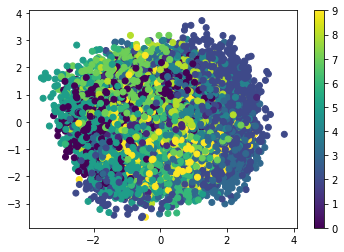

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(zs[:,0], zs[:, 3], c=labels)
plt.colorbar()

print(zs.shape)
print (zs[0])
print (y)
print (labels)

In [23]:
#t-sne dimensionality reduction

import time
from sklearn.manifold import TSNE

In [24]:
#t-sne in 2D

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(zs)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.069s...
[t-SNE] Computed neighbors for 60000 samples in 145.807s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for 

In [25]:
#import plotly.plotly as py
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

x = tsne_results[:, 0]
y = tsne_results[:, 1]
z = labels 

trace1 = go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(
        size=2,
        color=labels,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8,
        showscale=True
    ),
    text=labels,
    hoverinfo='text'
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link = False)

In [26]:
#next section is about transformation of one object into another

model.eval()
fun_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2, shuffle=True)
#chose 2 random samples from dataset
i = 0

for x, y in fun_loader:
    if i == 0:
    # we're only going to infer, so no autograd at all required: volatile=True
        data = Variable(x)
    else:
        break

start_point = Variable(data[0])
finish_point = Variable(data[1])

IndexError: index 1 is out of bounds for dimension 0 with size 1

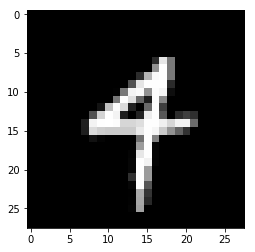

In [27]:
print("show start point: ", show_data(start_point))


IndexError: index 1 is out of bounds for dimension 0 with size 1

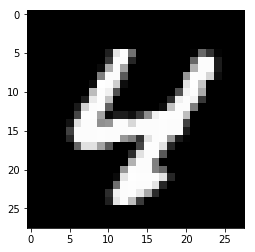

In [28]:
print("show finish point: ", show_data(finish_point))

In [29]:
#iterate by alpha and generate transitional objects
for alpha in torch.arange(0.0, 1.0, 0.1):
    generated_images = model.generation_with_interpolation(start_point, finish_point, alpha)
    save_image(generated_images.data.view(1, 1, 28, 28),'./generated/output_interpolate_'+ str(alpha) +'.png')